In [1]:
import json

from pathlib import Path
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt
import seaborn as sns

project_dir = Path().resolve().parents[0]

In [2]:
# Load the datasets
human_df = pd.read_csv(project_dir / "data" / "raw" / "Human.csv")
sybil_df = pd.read_csv(project_dir / "data" / "raw" / "Sybil.csv")

# Get basic information about the datasets
human_info = human_df.info()
sybil_info = sybil_df.info()

# Display the first few rows of each dataset
human_head = human_df.head()
sybil_head = sybil_df.head()

human_head, sybil_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   publicaddress     127 non-null    object
 1   Confidence Score  127 non-null    int64 
 2   passport          127 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6936 entries, 0 to 6935
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   publicaddress  6936 non-null   object
 1   passport       6936 non-null   object
dtypes: object(2)
memory usage: 108.5+ KB


(                                publicaddress  Confidence Score   
 0  0xe1a3435b683d863bcb6c8aa093de08ed0557ee99                 2  \
 1  0x5d76a92b7cb9e1a81b8eb8c16468f1155b2f64f4                 2   
 2  0x38123a191e9685448658d2207b0543e2fb9282cc                 0   
 3  0xb2f4b16595e02a9721f97e3e30fb5bbbf73f5f54                 2   
 4  0x8b580433568e521ad351b92b98150c0c65ce69b7                 2   
 
                                             passport  
 0  [{'type': ['VerifiableCredential'], 'proof': {...  
 1  [{'type': ['VerifiableCredential'], 'proof': {...  
 2  [{'type': ['VerifiableCredential'], 'proof': {...  
 3  [{'type': ['VerifiableCredential'], 'proof': {...  
 4  [{'type': ['VerifiableCredential'], 'proof': {...  ,
                                 publicaddress   
 0  0x0b0a55892285e9619872b570c605e1e668a8788c  \
 1  0x49181a7dc4e917a4f18ca0ac949ca06fb0888996   
 2  0x6a2e837f42741a482f765547b295ff5dffa0a02a   
 3  0x981234abd460018ac60b0ca82d5dea225fe0c6dc   
 4 

From the preliminary exploration:

- The Human dataset consists of 127 entries with 3 columns: publicaddress, Confidence Score, and passport.
- The Sybil dataset consists of 6,936 entries with 2 columns: publicaddress and passport.
- The passport column contains JSON data that represents various credentials.

## Preprocessing

In [3]:
def extract_features_from_passport(passport_str):
    """
    Extract key features from a passport JSON string.
    Returns:
    - Number of credentials
    - List of providers
    """
    # Fix the JSON formatting
    passport_str = passport_str.replace("'", '"')
    
    try:
        passport_json = json.loads(passport_str)
    except:
        return pd.Series([None, None, []])
    
    # Number of credentials in the passport
    num_credentials = len(passport_json)
    
    # Extract unique providers
    providers = []
    for entry in passport_json:
        subject = entry.get('credentialSubject', {})
        provider = subject.get('provider')
        if provider:
            providers.append(provider)
    
    return pd.Series([num_credentials, providers])

In [4]:
# Add label columns
human_df['label'] = 'Human'
sybil_df['label'] = 'Sybil'

In [5]:
# Combine datasets
combined_df = pd.concat([human_df, sybil_df], axis=0, ignore_index=True)

# Drop Confidence Score
combined_df.drop('Confidence Score', axis=1, inplace=True)

In [6]:
# Extract features from passport data
features = combined_df['passport'].apply(extract_features_from_passport)
combined_df[['num_credentials', 'providers']] = features

In [7]:
# One-hot encode providers
mlb = MultiLabelBinarizer()
encoded_providers = mlb.fit_transform(combined_df['providers'])
encoded_providers_df = pd.DataFrame(encoded_providers, columns=mlb.classes_)

# Merge encoded providers and drop unnecessary columns
combined_df = pd.concat([combined_df, encoded_providers_df], axis=1)
combined_df.drop(['providers', 'passport'], axis=1, inplace=True)

## EDA

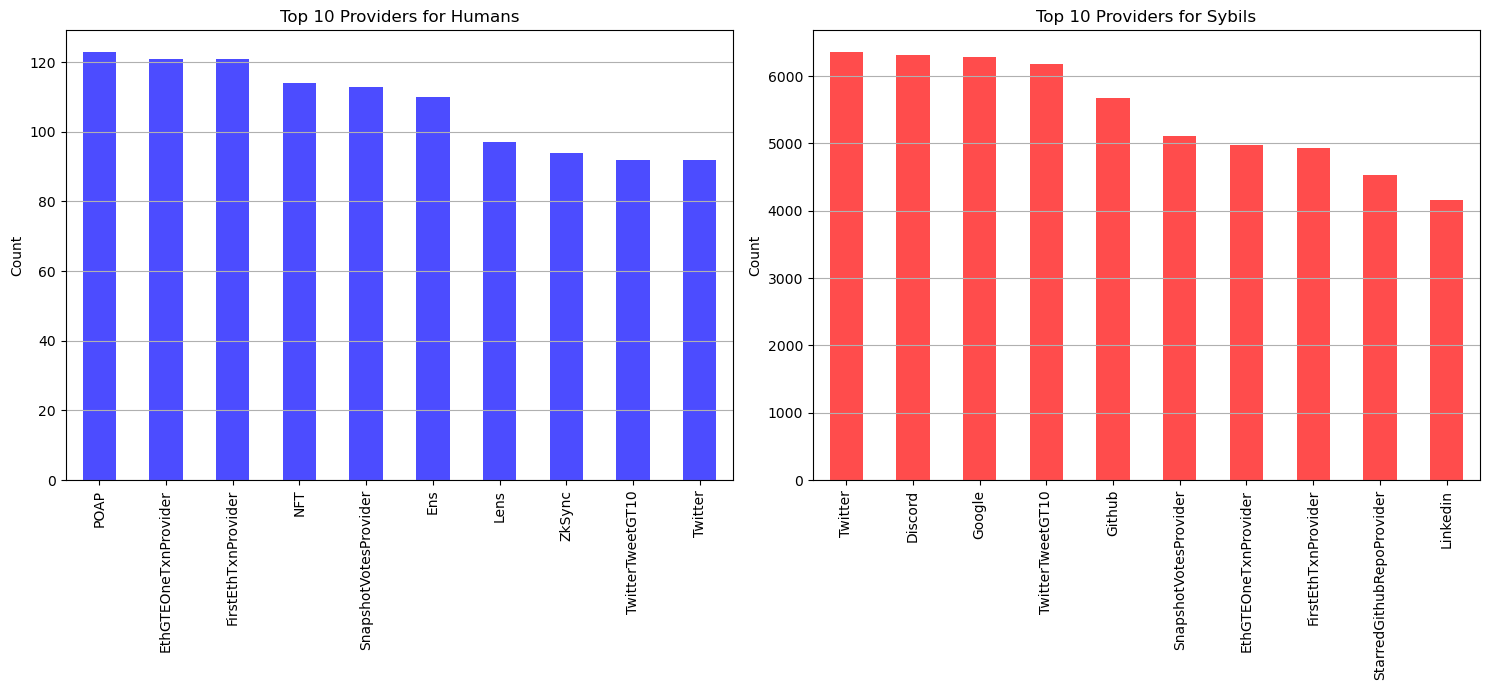

In [8]:
def count_providers(combined_df):
    # Split the dataframe into Human and Sybil subsets
    human_subset = combined_df[combined_df['label'] == 'Human']
    sybil_subset = combined_df[combined_df['label'] == 'Sybil']
    
    # Count 1s for each provider column
    human_counts = human_subset.drop(columns=['publicaddress', 'label', 'num_credentials']).sum()
    sybil_counts = sybil_subset.drop(columns=['publicaddress', 'label', 'num_credentials']).sum()
    
    return human_counts, sybil_counts

human_counts, sybil_counts = count_providers(combined_df)

# Plotting
plt.figure(figsize=(15, 7))

# Human providers
plt.subplot(1, 2, 1)
human_counts.sort_values(ascending=False).head(10).plot(kind='bar', color='blue', alpha=0.7)
plt.title('Top 10 Providers for Humans')
plt.ylabel('Count')
plt.grid(axis='y')

# Sybil providers
plt.subplot(1, 2, 2)
sybil_counts.sort_values(ascending=False).head(10).plot(kind='bar', color='red', alpha=0.7)
plt.title('Top 10 Providers for Sybils')
plt.ylabel('Count')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

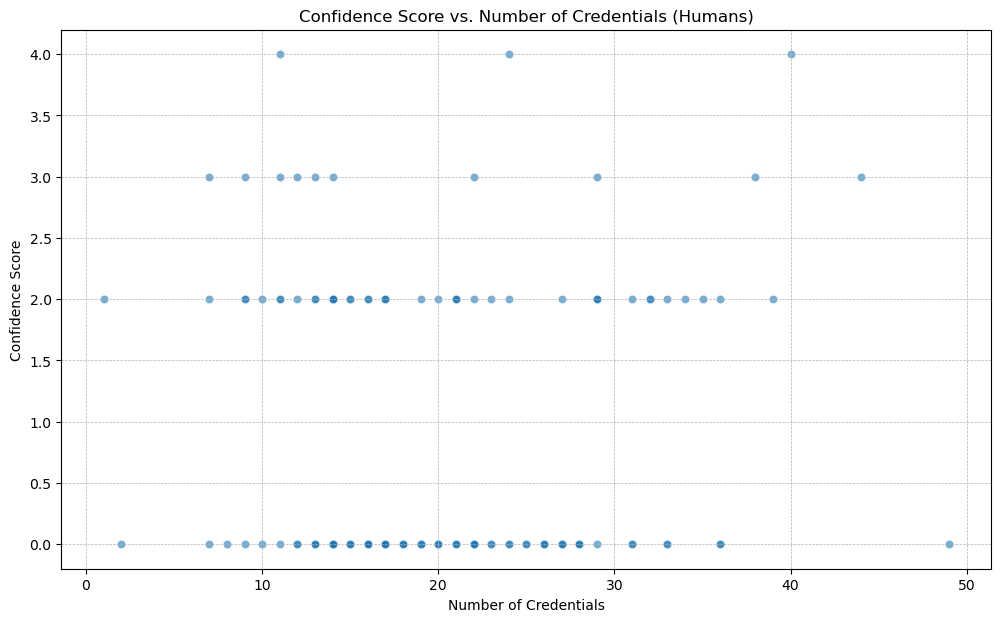

In [10]:
# Extract the num_credentials feature for Human data
human_df['num_credentials'] = human_df['passport'].apply(lambda x: len(json.loads(x.replace("'", '"'))))

# Scatter plot of Confidence Score vs. num_credentials
plt.figure(figsize=(12, 7))
plt.scatter(human_df['num_credentials'], human_df['Confidence Score'], alpha=0.6, edgecolors="w", linewidth=0.5)
plt.title('Confidence Score vs. Number of Credentials (Humans)')
plt.xlabel('Number of Credentials')
plt.ylabel('Confidence Score')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Model Training

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Splitting data into features and target
X = combined_df.drop(columns=['publicaddress', 'label'])
y = combined_df['label']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initializing and training the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred = rf_classifier.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

In [22]:
accuracy

0.9886765746638358

In [23]:
conf_matrix

array([[  11,   14],
       [   2, 1386]])

<Axes: >

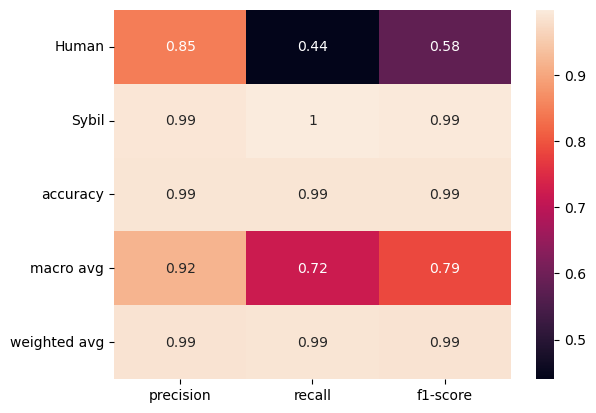

In [26]:
sns.heatmap(pd.DataFrame(class_report).iloc[:-1, :].T, annot=True)

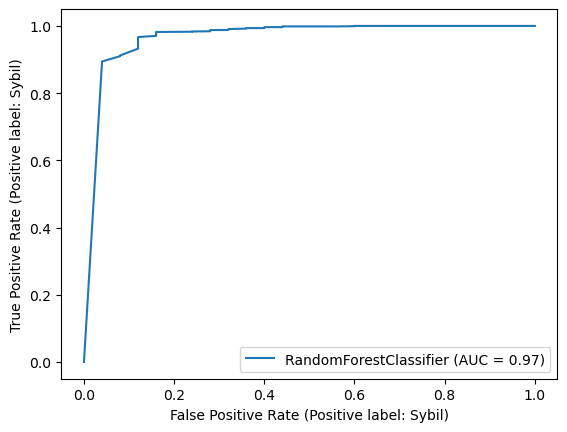

In [28]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(rf_classifier, X_test, y_test)

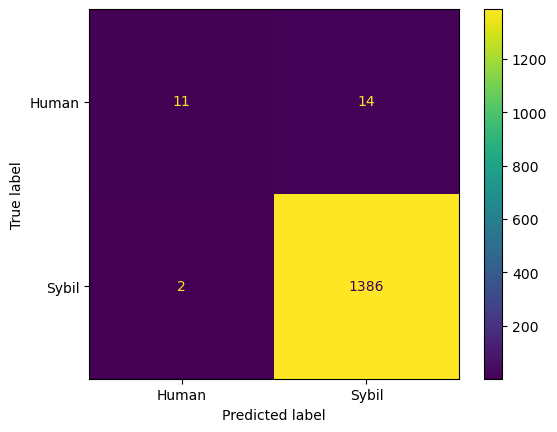

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(rf_classifier, X_test, y_test)

## Oversampling

In [38]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Train the Random Forest Classifier on the oversampled data
rf_classifier_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_smote.fit(X_train_oversampled, y_train_oversampled)

# Predictions using the model trained on oversampled data
y_pred_smote = rf_classifier_smote.predict(X_test)

# Evaluation
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
class_report_smote = classification_report(y_test, y_pred_smote, output_dict=True)

In [39]:
accuracy_smote

0.9837225760792639

In [40]:
conf_matrix_smote

array([[  11,   14],
       [   9, 1379]])

<Axes: >

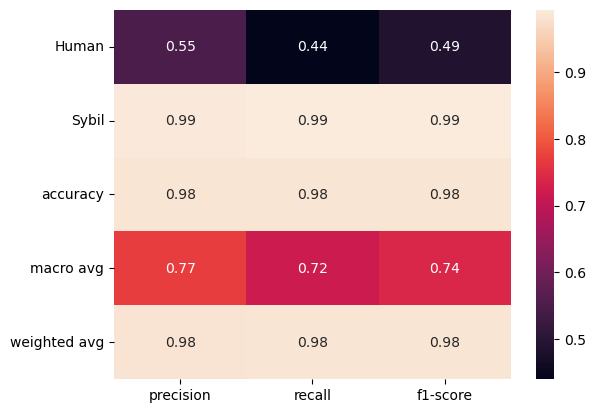

In [41]:
sns.heatmap(pd.DataFrame(class_report_smote).iloc[:-1, :].T, annot=True)

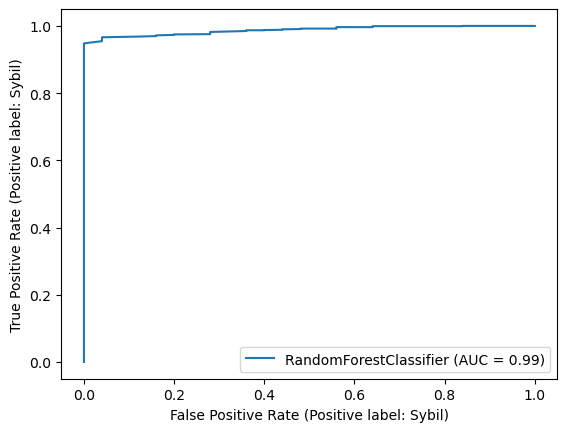

In [42]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(rf_classifier_smote, X_test, y_test)

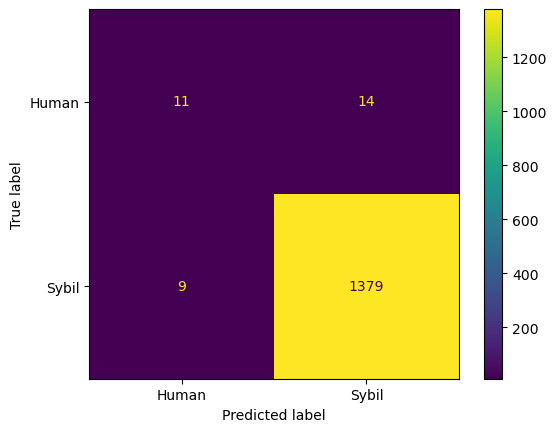

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(rf_classifier_smote, X_test, y_test)

## Undersampling

In [48]:
from sklearn.utils import resample

# Separate majority (Sybil) and minority (Human) classes
df_majority = combined_df[combined_df.label=='Sybil']
df_minority = combined_df[combined_df.label=='Human']

# Undersample majority class
df_majority_undersampled = resample(df_majority, 
                                    replace=False, 
                                    n_samples=len(df_minority), 
                                    random_state=42)

# Combine minority class with undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Splitting the undersampled dataset into features and target
X_undersampled = df_undersampled.drop(columns=['publicaddress', 'label'])
y_undersampled = df_undersampled['label']

# Splitting data into training and test sets
X_train_undersampled, X_test_undersampled, y_train_undersampled, y_test_undersampled = train_test_split(
    X_undersampled, y_undersampled, test_size=0.2, random_state=42, stratify=y_undersampled)

# Train Random Forest on the undersampled dataset
rf_classifier_undersampled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_undersampled.fit(X_train_undersampled, y_train_undersampled)

# Predictions
y_pred_undersampled = rf_classifier_undersampled.predict(X_test_undersampled)

# Evaluation
accuracy_undersampled = accuracy_score(y_test_undersampled, y_pred_undersampled)
conf_matrix_undersampled = confusion_matrix(y_test_undersampled, y_pred_undersampled)
class_report_undersampled = classification_report(y_test_undersampled, y_pred_undersampled, output_dict=True)

In [49]:
accuracy_undersampled

0.9215686274509803

In [50]:
conf_matrix_undersampled

array([[25,  1],
       [ 3, 22]])

<Axes: >

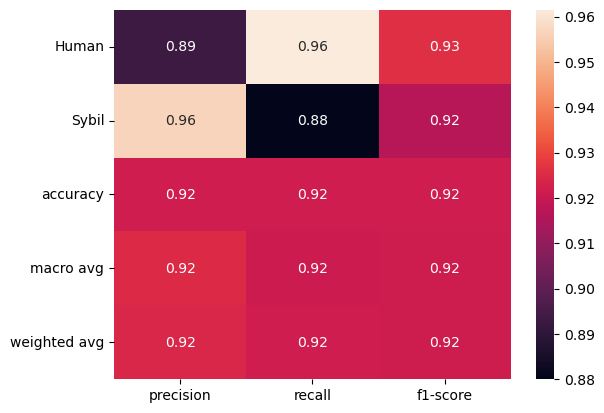

In [51]:
sns.heatmap(pd.DataFrame(class_report_undersampled).iloc[:-1, :].T, annot=True)

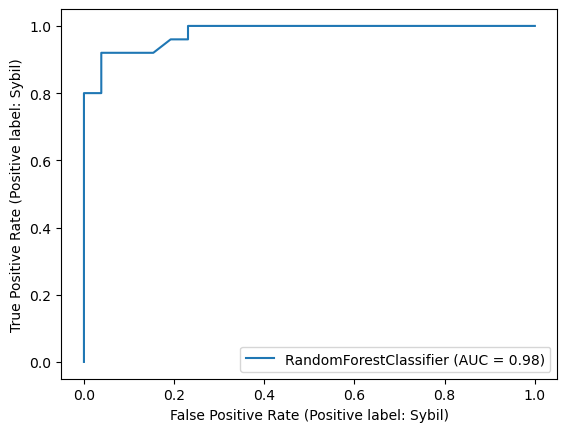

In [54]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(rf_classifier_undersampled, X_test_undersampled, y_test_undersampled)

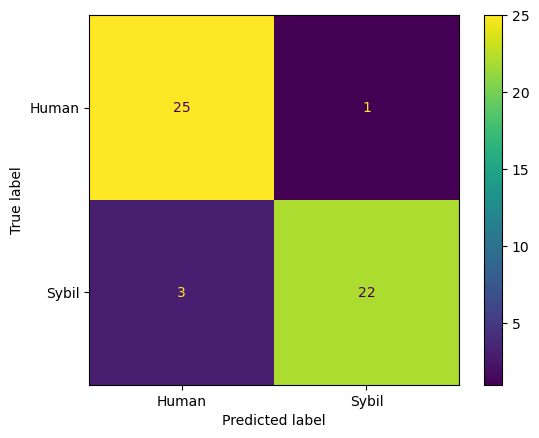

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(rf_classifier_undersampled, X_test_undersampled, y_test_undersampled)

In [57]:
# Splitting the original data into training and test sets (without resampling)
X_original = combined_df.drop(columns=['publicaddress', 'label'])
y_original = combined_df['label']
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original)

# Predictions using the model trained on undersampled data
y_pred_original = rf_classifier_undersampled.predict(X_test_original)

# Evaluation
accuracy_original = accuracy_score(y_test_original, y_pred_original)
conf_matrix_original = confusion_matrix(y_test_original, y_pred_original)
class_report_original = classification_report(y_test_original, y_pred_original, output_dict=True)

In [61]:
accuracy_original

0.913658881811748

In [62]:
conf_matrix_original

array([[  24,    1],
       [ 121, 1267]])

<Axes: >

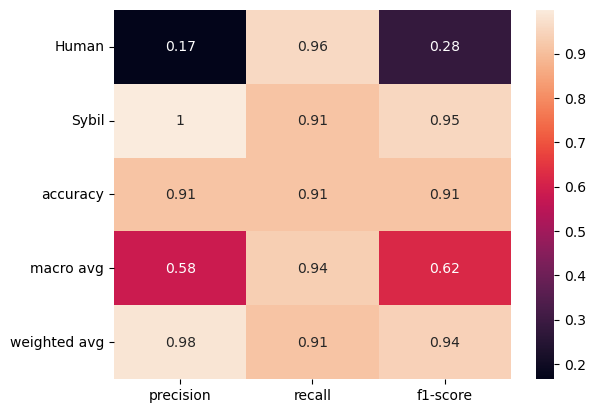

In [75]:
sns.heatmap(pd.DataFrame(class_report_original).iloc[:-1, :].T, annot=True)

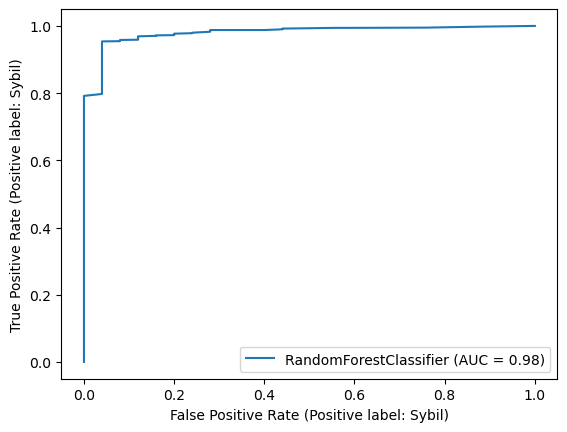

In [76]:
from sklearn.metrics import RocCurveDisplay


RocCurveDisplay.from_estimator(rf_classifier_undersampled, X_test_original, y_test_original)

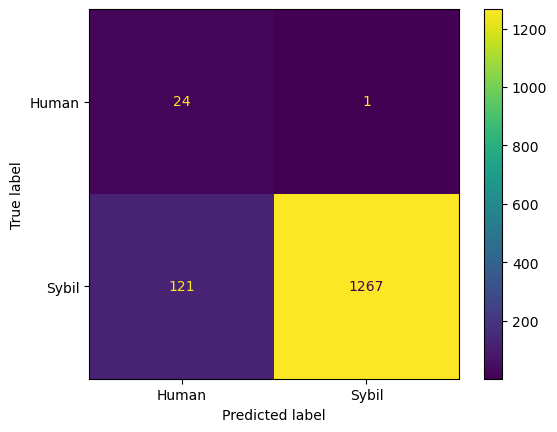

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay


ConfusionMatrixDisplay.from_estimator(rf_classifier_undersampled, X_test_original, y_test_original)

## Feature Importance

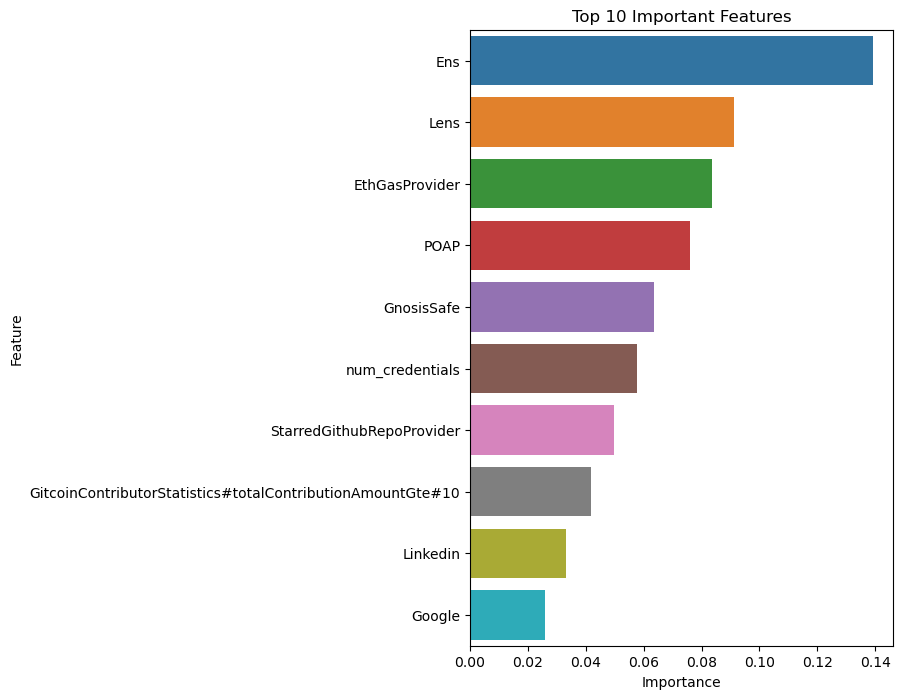

In [81]:
# Extract feature importances from the Random Forest model
feature_importances = rf_classifier_undersampled.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train_undersampled.columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
features_df_sorted = features_df.sort_values(by='Importance', ascending=False)

# Plotting the top 10 important features
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=features_df_sorted.head(10))
plt.title('Top 10 Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

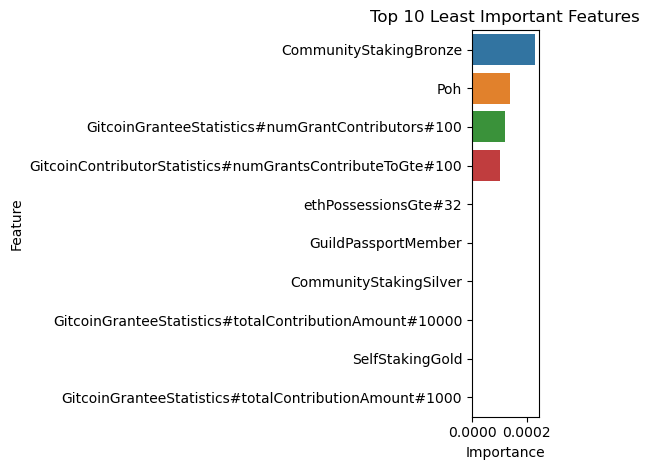

In [82]:
# Plotting the top 10 least important features
plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=features_df_sorted.tail(10))
plt.title('Top 10 Least Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [86]:
# Generate probabilities for the test set
y_pred_proba = rf_classifier_undersampled.predict_proba(X_test_original)
wrongly_classified_indices = y_test_original[y_test_original != y_pred_original].index
wrongly_classified_probabilities = y_pred_proba[y_test_original.index.isin(wrongly_classified_indices)]

wrongly_classified_df = pd.DataFrame(wrongly_classified_probabilities, columns=['Prob_Human', 'Prob_Sybil'], index=wrongly_classified_indices)
wrongly_classified_df['True_Label'] = y_test_original[wrongly_classified_indices]
wrongly_classified_df['Predicted_Label'] = y_pred_original[y_test_original.index.isin(wrongly_classified_indices)]

wrongly_classified_df.head()

,Prob_Human,Prob_Sybil,True_Label,Predicted_Label
2753,0.84,0.16,Sybil,Human
5391,0.56,0.44,Sybil,Human
4134,0.52,0.48,Sybil,Human
3382,0.95,0.05,Sybil,Human
4471,0.88,0.12,Sybil,Human


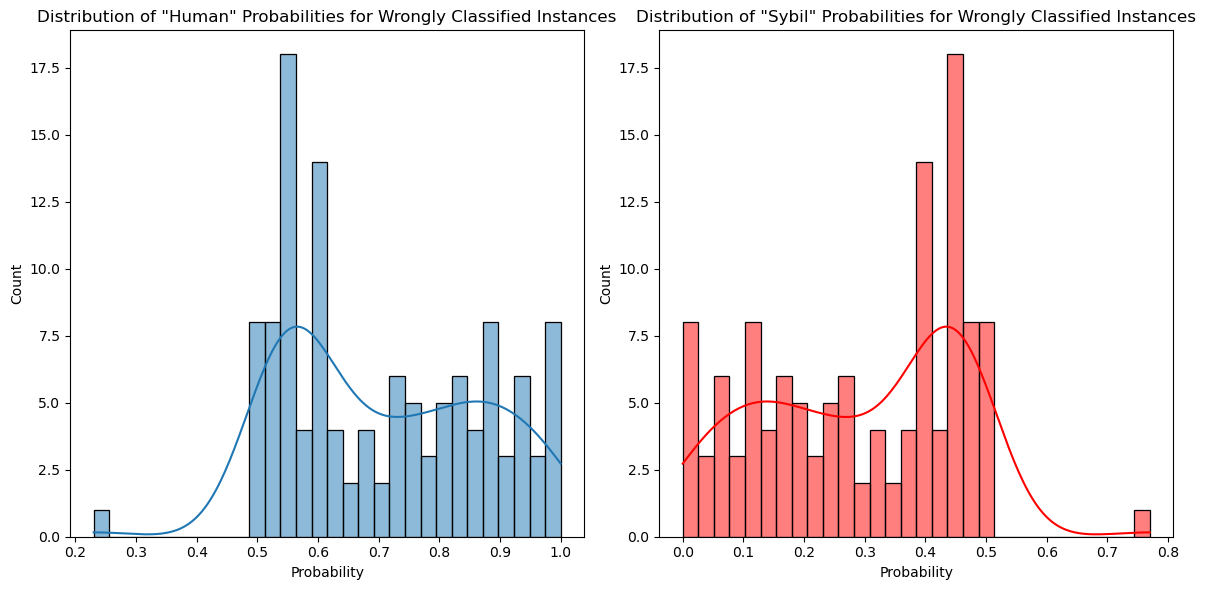

Prob_Human    0.707295
Prob_Sybil    0.292705
dtype: float64

In [87]:
# Compute the average probability for both classes for wrongly classified instances
avg_probabilities = wrongly_classified_df[['Prob_Human', 'Prob_Sybil']].mean()

# Visualize the distribution of probabilities for wrongly classified instances
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(wrongly_classified_df['Prob_Human'], kde=True, bins=30)
plt.title('Distribution of "Human" Probabilities for Wrongly Classified Instances')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.histplot(wrongly_classified_df['Prob_Sybil'], kde=True, bins=30, color='red')
plt.title('Distribution of "Sybil" Probabilities for Wrongly Classified Instances')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

avg_probabilities
